In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from multiprocessing.dummy import Pool
import os
from sklearn.model_selection import train_test_split
import keras.preprocessing.image  as preprocess_image
import numpy as np

/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/volodymyr/envs/ahegao_env/lib/python3.7/site-pack

# Loading the model

In [2]:
model_emotions = tf.keras.models.load_model('../big_full_model.h5', compile=False)

In [3]:
model_emotions.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
separable_conv2d_10 (Separab (None, 4, 4, 128)         181376    
_________________________________________________________________
batch_normalization_10 (Batc (None, 4, 4, 128)         512       
_________________________________________________________________
dense_28 (Dense)             (None, 4, 4, 2048)        264192    
_________________________________________________________________
dropout_19 (Dropout)         (None, 4, 4, 2048)        0         
_________________________________________________________________
dense_29 (Dense)             (None, 4, 4, 1024)        209

# Loading the dataset

In [4]:
def load_data(path_dataframe, abs_path, width=128, height=128, workers=12,step=100):
    def load(x):
        images = []
        target_size = x[1:]
        pathes = x[0]
        for i in pathes:
            image = preprocess_image.img_to_array(preprocess_image.load_img(i, color_mode='rgb',
                                                                            target_size=target_size),
                                                  data_format='channels_last', dtype=np.float32) / 255
            images.append(image)
        return images

    df = pd.read_csv(path_dataframe)
    df['path'] = df['path'].apply(lambda x: os.path.join(abs_path, x))
    X_train, X_test = train_test_split(df, test_size=0.15, random_state=1)
    training_labels, testing_labels = X_train['label'].values, X_test['label'].values
    tup_train = [(X_train['path'].values[i:i + step], height, width) for i in
                 range(0, len(X_train['path'].values), step)]
    tup_test = [(X_test['path'].values[i:i + step], height, width) for i in range(0, len(X_test['path'].values), step)]
    with Pool(workers) as p:
        training_images = p.map(load, tup_train)
        testing_images = p.map(load, tup_test)
    training_images = np.array([z for i in training_images for z in i])
    testing_images = np.array([z for i in testing_images for z in i])
    nb_classes = df['label'].nunique()

    return (training_images, training_labels), (testing_images, testing_labels), nb_classes

In [5]:
(training_images, training_labels), (testing_images, testing_labels), nb_classes= load_data('../data.csv','/home/volodymyr')

In [6]:
len(training_images)

12526

In [7]:
training_images.shape

(12526, 128, 128, 3)

# Visualization of the weights

In [57]:
layer_conv = [layer.output for layer in model_emotions.layers if 'dense' in layer.name]

In [58]:
layer_conv

[<tf.Tensor 'dense_28/Relu:0' shape=(None, 4, 4, 2048) dtype=float32>,
 <tf.Tensor 'dense_29/Relu:0' shape=(None, 4, 4, 1024) dtype=float32>,
 <tf.Tensor 'dense_30/BiasAdd:0' shape=(None, 6) dtype=float32>]

In [59]:
activation_model  = tf.keras.models.Model(inputs=model_emotions.inputs, outputs=layer_conv[0])

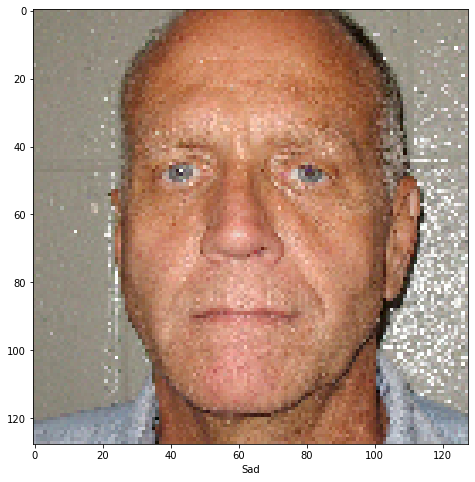

In [68]:
idx = np.random.randint(0,len(training_images))
image = training_images[idx]
label = training_labels[idx]
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.grid([])
plt.xlabel(label);

In [69]:
prediction = activation_model.predict(np.expand_dims(image,axis=0))

In [70]:
prediction.shape

(1, 4, 4, 2048)

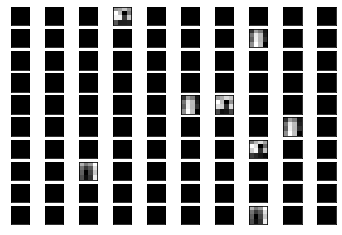

In [72]:
square = 10
ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(prediction[0, :, :, ix-1], cmap='gray')
		ix += 1